# ***XGBM & LGBM***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
train_data = pd.read_csv('/content/sample_data/Titanic_train.csv')
test_data = pd.read_csv('/content/sample_data/Titanic_test.csv')

# Display the first few rows of the training data
print(train_data.head())

# Check for missing values
print(train_data.isnull().sum())
print(test_data.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
Pa

In [3]:
# Display the column names to verify
print("Train data columns:", train_data.columns)
print("Test data columns:", test_data.columns)

# Impute missing values
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
train_data['Cabin'].fillna('U', inplace=True)

test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)
test_data['Cabin'].fillna('U', inplace=True)

Train data columns: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Test data columns: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


<ipython-input-3-79936c7422be>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
<ipython-input-3-79936c7422be>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [4]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

In [5]:
label = LabelEncoder()
for col in ['Sex', 'Embarked']:
    train_data[col] = label.fit_transform(train_data[col])
    test_data[col] = label.transform(test_data[col])

# Convert 'Cabin' feature to the first letter (deck)
train_data['Cabin'] = train_data['Cabin'].map(lambda x: x[0])
test_data['Cabin'] = test_data['Cabin'].map(lambda x: x[0])

# One-hot encode 'Cabin' feature
train_data = pd.get_dummies(train_data, columns=['Cabin'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Cabin'], drop_first=True)

# Ensure the 'Survived' column exists
if 'Survived' not in train_data.columns:
    raise KeyError("'Survived' column is missing from the training data")

In [6]:
# Display the first few rows of the preprocessed training data
print(train_data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1      0   
2                             Heikkinen, Miss. Laina    0  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1      0   
4                           Allen, Mr. William Henry    1  35.0      0      0   

             Ticket     Fare  Embarked  Cabin_B  Cabin_C  Cabin_D  Cabin_E  \
0         A/5 21171   7.2500         2    False    False    False    False   
1          PC 17599  71.2833         0    False     True    False    False   
2  STON/O2. 3101282   7.9250         2    False    False    Fa

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [8]:
# Split the data
X = train_data.drop(['Survived', 'Name', 'Ticket'], axis=1)
y = train_data['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_val)
lgb_metrics = evaluate_model(y_val, lgb_pred)
print(f"LightGBM Metrics: {lgb_metrics}")

# XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)
xgb_metrics = evaluate_model(y_val, xgb_pred)
print(f"XGBoost Metrics: {xgb_metrics}")

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

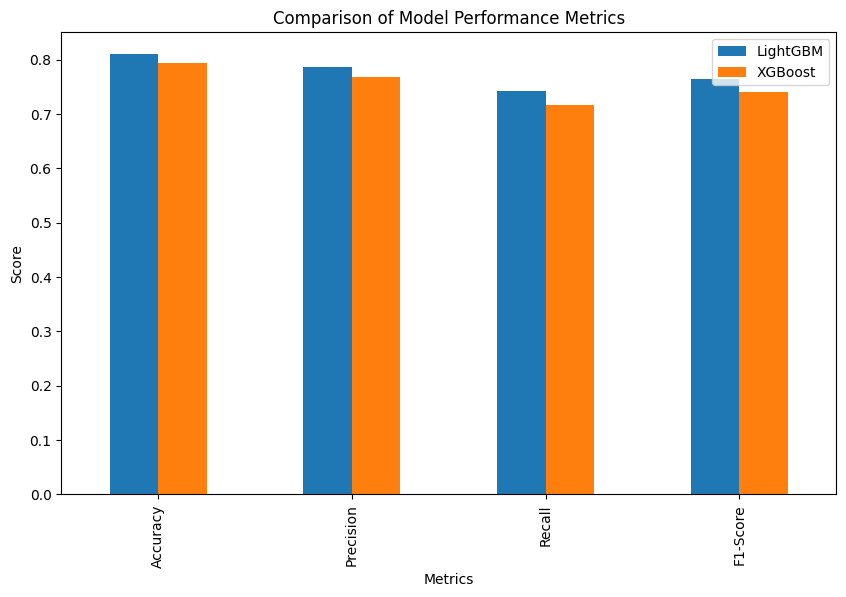

In [9]:
# Create a DataFrame to compare the metrics
metrics_df = pd.DataFrame({
    'Metrics': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'LightGBM': lgb_metrics,
    'XGBoost': xgb_metrics
})

# Plot the comparison
metrics_df.plot(x='Metrics', kind='bar', figsize=(10, 6))
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.show()

# Conclusion:
The bar plot indicates the performance of both models across different metrics. From this comparative analysis, we can identify which model performs better on the Titanic dataset and understand the strengths and weaknesses of each algorithm.

This code provides a comprehensive approach to compare the performance of LightGBM and XGBoost on the Titanic dataset. You can further refine and optimize the models using techniques like cross-validation and hyperparameter tuning for better performance